# Classify & Integrate query to reference (offline)

In this notebook, we are going to integrate 5 different pancreas datasets with scArches' pipeline. 

First, we load all 5 pancreas datasets and separate query and reference datasets. Next, we train a network on 3 pancreas datasets (3 reference datasets). Then, we will perform architecture surgery and add 2 more condition to the network (2 query conditions). In the next step, we will fine-tune the new scArches network on 2 other pancreas datasets which we call them query datasets. Finally, we use MMD latent projection of 5 integrated datasets to annotate cell types of query cells with weighted KNN. 

In general, scArches' pipeline consists of the following steps:

1. Load & Pre-process the reference datasets
2. Train scArches with reference datasets
    - Qualitatively evaluate trained scArches with MMD space reference projection UMAPs
3. Load & Pre-process the query datasets
4. Perform architecture surgery and add query conditions 
5. Train new scArches network (which has much less trainable parameters) on query datasets
    - Qualitatively evaluate trained scArches with MMD space query projection UMAPs
    - Qualitatively evaluate trained scArches with MMD space query&reference projection UMAPs
6. Annotate cell types of query cells by training weighted KNN on MMD latent projection of reference datasets.

## Config GPU

If you are planning to run on one of your GPUs (Here GPU #4), you can set the environment variable `CUDA_VISIBLE_DEVICES` with the ID of your GPU.

In [1]:
import os
os.chdir("../")
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import scarches as sca
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')

Using TensorFlow backend.


In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2"]

## Loading data

In [4]:
adata = sca.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Now we separate query(target) and reference(source) datasets

In [5]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 12720 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [6]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 2961 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [7]:
source_conditions = source_adata.obs[condition_key].unique().tolist()

## Create an instance of scArches model

In [8]:
network = sca.models.scArches(task_name='pancreas_reference',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 32],
                              gene_names=adata.var_names.tolist(),
                              conditions=source_conditions,
                              alpha=0.0001,
                              beta=20,
                              eta=100,
                              use_batchnorm=False,
                              loss_fn='mse',
                              model_path="./models/scArches/",
                              )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
scArches' network has been successfully constructed!
scArches' network has been successfully compiled!


## Train scArches

You can train scArches with `train` function with the following parameters:

1. __adata__: Annotated dataset used for training and evaluating scArches.
2. __condition_key__: name of the column in `obs` matrix in `adata` which contains the conditions for each sample.
3. __n_epochs__: number of epochs used to train scArches.
4. __batch_size__: number of sample used to sample as mini-batches in order to optimize scArches. Please __NOTE__ that for MSE loss with MMD regularization batch sizes upper that 512 is highly recommended.
8. __save__: whether to save scArches' model and configs after training phase or not. 
9. __retrain__: if `False` and scArches' pretrained model exists in `model_path`, will restore scArches' weights. Otherwise will train and validate scArches on `adata`. 

In [10]:
network.train(source_adata,
              condition_key=condition_key,
              batch_size=512,
              )

 |████████████████████| 100.0%  - loss: 101.0953 - mmd_loss: 4.1514 - reconstruction_loss: 96.9439 - val_loss: 98.0164 - val_mmd_loss: 3.9143 - val_reconstruction_loss: 94.102144

scArches has been successfully saved in ./models/scArches/pancreas_reference.


## Get latent output for the reference dataset

Latent space representation of reference data can be computed using `get_latent` function
This function has the following parameters:

1. __adata__: Annotated dataset to be transformed to latent space
2. __condition_key__: Name of the column in `obs` matrix in `adata` which contains the study for each sample.


In [11]:
latent_adata = network.get_latent(source_adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 12720 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## UMAP visualization of reference latent with Scanpy

In [12]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

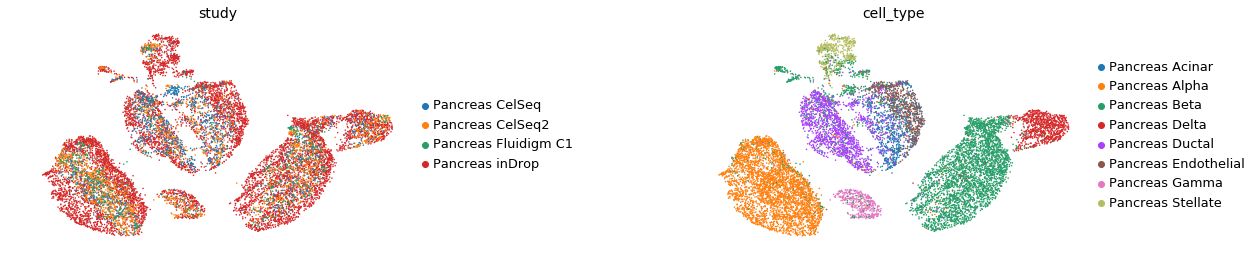

In [13]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           frameon=False, wspace=0.6)

## architecture Surgery (scArches)
In order to perform Architecture surgery on pre-trained scArches model, `operate` function is available with the following arguments:

1. __network__: pre-trained scArches object.
2. __new_task_name__: name of the task you want to solve (related to query atlas you have)
3. __new_conditions__: list of (unique) new studies.
4. __version__: version of scArches you want to use. Must be one of "scArches", "scArches v1", or "scArches v2".

In [14]:
new_network = sca.operate(network,
                          new_task_name="pancreas_query",
                          new_conditions=target_conditions,
                          version='scArches',
                          )

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


## Train with query dataset

In [15]:
new_network.train(target_adata,
                  condition_key=condition_key,
                  batch_size=512, 
                 )

 |████████████████████| 100.0%  - loss: 104.9023 - mmd_loss: 0.0000 - reconstruction_loss: 104.9023 - val_loss: 105.9033 - val_mmd_loss: 0.0000 - val_reconstruction_loss: 105.9033

scArches has been successfully saved in ./models/scArches/pancreas_query.


## Project query+reference data in to the latent space

In [19]:
latent_adata = new_network.get_latent(adata, condition_key)

In [20]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

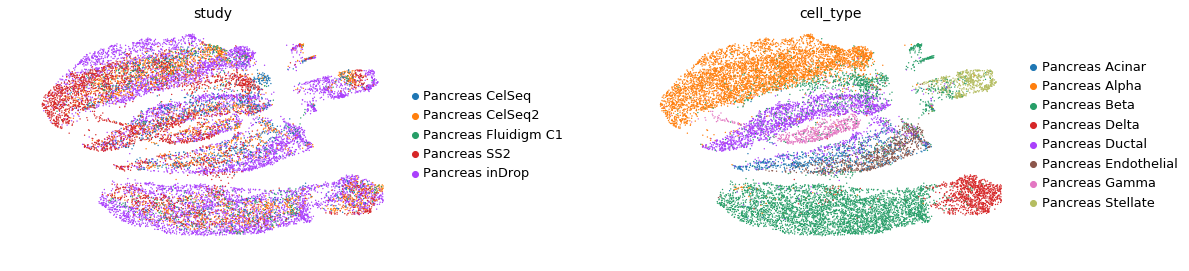

In [21]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           wspace=0.5, frameon=False)

## Weighted KNN
In order to annotate cell types in the query data (`target_adata`), you can use `scArches.ann.weighted_knn` function. There are a few arguments explained below.

1. __n_neighbors__: Number of nearest neighbors used to train the weighted KNN classifier.
2. __threshold__: uncertainty threshold to be used to label cells with high uncertainty as 'Unknown'.
3. __label_key__: column with information about cell types in `obs` matrix of train/valid adatas.

In [22]:
n_neighbors = 20
threhsold = 0.5

### Project query and reference data in the latent space

In [23]:
train_latent = new_network.get_latent(source_adata, condition_key)
valid_latent = new_network.get_latent(target_adata, condition_key)

In [24]:
sca.ann.weighted_knn(train_latent, 
                     valid_latent,
                     label_key=cell_type_key,
                     n_neighbors=n_neighbors,
                     threshold=threhsold,
                     )

Weighted KNN with n_neighbors = 20 and threshold = 0.5 ... finished!
Number of correctly classified samples: 2395
Number of misclassified samples: 501
Number of samples classified as unknown: 65


## UMAP visualization of correct/incorrect/unknown cells

... storing 'pred_cell_type' as categorical
... storing 'evaluation' as categorical


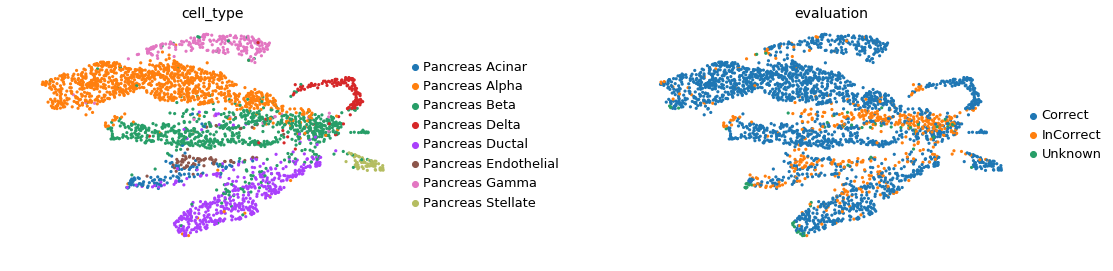

In [25]:
sc.pp.neighbors(valid_latent)
sc.tl.umap(valid_latent)
sc.pl.umap(valid_latent, color=[cell_type_key, 'evaluation'], wspace=0.5, frameon=False)

## Uncertainty UMAP visualization 

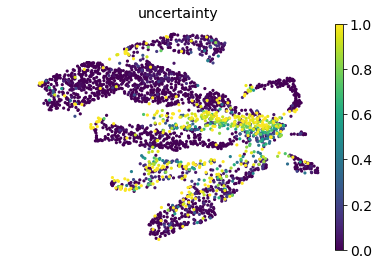

In [26]:
sc.pl.umap(valid_latent, color='uncertainty', frameon=False)

## Uncertainty violin plots for each group (correct/incorrect/unknown) of cells

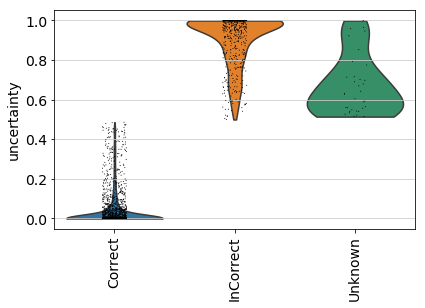

In [27]:
sc.pl.violin(valid_latent, keys='uncertainty', groupby='evaluation', rotation=90)